In [1]:

# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import os

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

import tensorflow as tf
import keras
from keras.models import Sequential
from keras.layers import Dense, Conv2D , MaxPool2D , Flatten , Dropout 
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam

from sklearn.metrics import classification_report,confusion_matrix

import cv2

import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns

from PIL import Image
from IPython.display import Image, display


# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

# import os
# for dirname, _, filenames in os.walk('/kaggle/input'):
#     for filename in filenames:
#         print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [2]:
print('Tensorflow version:', tf.__version__)
print('Keras version:', tf.keras.__version__)

Tensorflow version: 2.6.4
Keras version: 2.6.0


## Creating Path to Store Training/Testing Images

In [3]:
def create_dir(path):
    if  os.path.exists(path) != True:
        os.mkdir(path)
        print(path+" -> created")
    else:
        print(path+" -> exists")

In [4]:
create_dir('/kaggle/working/proj0622')
create_dir('/kaggle/working/proj0622/train')
create_dir('/kaggle/working/proj0622/test')
create_dir('/kaggle/working/proj0622/train/bj')
create_dir('/kaggle/working/proj0622/train/breyers')
create_dir('/kaggle/working/proj0622/train/hd')
create_dir('/kaggle/working/proj0622/train/talenti')
create_dir('/kaggle/working/proj0622/test/bj')
create_dir('/kaggle/working/proj0622/test/breyers')
create_dir('/kaggle/working/proj0622/test/hd')
create_dir('/kaggle/working/proj0622/test/talenti')


/kaggle/working/proj0622 -> created
/kaggle/working/proj0622/train -> created
/kaggle/working/proj0622/test -> created
/kaggle/working/proj0622/train/bj -> created
/kaggle/working/proj0622/train/breyers -> created
/kaggle/working/proj0622/train/hd -> created
/kaggle/working/proj0622/train/talenti -> created
/kaggle/working/proj0622/test/bj -> created
/kaggle/working/proj0622/test/breyers -> created
/kaggle/working/proj0622/test/hd -> created
/kaggle/working/proj0622/test/talenti -> created


## Copying Images from Input to Train/Test Directories

In [5]:
import shutil

src_root= '../input/ice-cream-dataset'
dest_train = '/kaggle/working/proj0622/train'
dest_test = '/kaggle/working/proj0622/test'

def copy_images_to_work(brand, cnt):
    
    files = os.listdir(src_root+'/'+brand +'/images')
    i=0
    for f in files:
        
        src = src_root+'/'+brand +'/images/'+f
        i = i + 1
    
        if i <= cnt :
            
            des = dest_train+'/'+brand+'/'+f
     
            if os.path.isfile(des) != True:
                shutil.copyfile(src, des)
                print(des+ '-> copied')
            else:
                print(des+' -> exists')
                
        else:
            
            des = dest_test+'/'+brand+'/'+f
     
            if os.path.isfile(des) != True:
                shutil.copyfile(src, des)  
                print(des+ '-> copied')
            else:
                print(des+' -> exists')
                    

In [6]:
copy_images_to_work('bj',41)
copy_images_to_work('breyers',51)
copy_images_to_work('hd',51)
copy_images_to_work('talenti',31)

/kaggle/working/proj0622/train/bj/23_bj.png-> copied
/kaggle/working/proj0622/train/bj/44_bj.png-> copied
/kaggle/working/proj0622/train/bj/19_bj.png-> copied
/kaggle/working/proj0622/train/bj/17_bj.png-> copied
/kaggle/working/proj0622/train/bj/31_bj.png-> copied
/kaggle/working/proj0622/train/bj/7_bj.png-> copied
/kaggle/working/proj0622/train/bj/18_bj.png-> copied
/kaggle/working/proj0622/train/bj/2_bj.png-> copied
/kaggle/working/proj0622/train/bj/13_bj.png-> copied
/kaggle/working/proj0622/train/bj/6_bj.png-> copied
/kaggle/working/proj0622/train/bj/20_bj.png-> copied
/kaggle/working/proj0622/train/bj/10_bj.png-> copied
/kaggle/working/proj0622/train/bj/37_bj.png-> copied
/kaggle/working/proj0622/train/bj/25_bj.png-> copied
/kaggle/working/proj0622/train/bj/14_bj.png-> copied
/kaggle/working/proj0622/train/bj/51_bj.png-> copied
/kaggle/working/proj0622/train/bj/15_bj.png-> copied
/kaggle/working/proj0622/train/bj/3_bj.png-> copied
/kaggle/working/proj0622/train/bj/41_bj.png-> copi

## Preparing Images for model (deprecated)

In [7]:
def create_images(target_dir, source_arr):
    for i in range(0,len(source_arr)):
    
        image = cv.imread(source_arr[i])
        gray = cv.cvtColor(image, cv.COLOR_BGR2GRAY)
    
        reshape_image = cv.resize(gray, (32, 32),interpolation = cv.INTER_NEAREST)
    
    
        head, tail = os.path.split(source_arr[i])
        imgfile = target_dir + "/" + tail
            
        if os.path.isfile(imgfile) != True:
            
            cv.imwrite(imgfile,reshape_image)                
            print("created: "+ imgfile)
            
        else: 
            print("Exists: "+ imgfile)
    

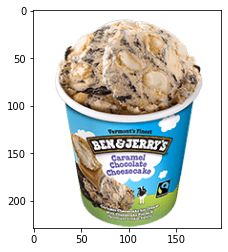

In [8]:
img = mpimg.imread('/kaggle/working/proj0622/train/bj/13_bj.png')

imgplot = plt.imshow(img)
plt.show()

## Asigning labels to training/testing images

In [9]:
LABELS = ['bj','breyers','hd','talenti']
IMG_SIZE = 32

IMG_HEIGHT = IMG_SIZE
IMG_WIDTH  = IMG_SIZE

def get_data(data_dir):
    data = []
    clas = []
    for label in LABELS: 
        path = os.path.join(data_dir, label)
      
        class_num = LABELS.index(label)
        for img in os.listdir(path):
            try:
                img_arr = cv2.imread(os.path.join(path, img))[...,::-1] #convert BGR to RGB format
                resized_arr = cv2.resize(img_arr, (IMG_HEIGHT, IMG_WIDTH)) # Reshaping images to preferred size
                data.append(resized_arr)
                clas.append(class_num)
            except Exception as e:
                print(e)
    #return np.array(data,dtype = "object")
    return data,clas

In [10]:
img_train,clas_train = get_data('/kaggle/working/proj0622/train')

In [11]:
img_test,clas_test = get_data('/kaggle/working/proj0622/test')

(32, 32, 3)


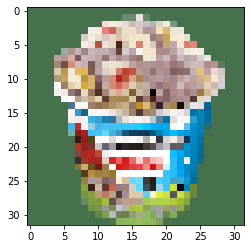

In [12]:
data = np.asarray(img_train[10])
print(data.shape)
imgplot = plt.imshow(data)
plt.show()

(32, 32, 3)


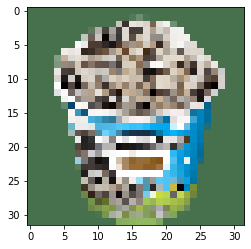

In [13]:
data = np.asarray(img_test[10])
print(data.shape)
imgplot = plt.imshow(data)
plt.show()

## Preparing images for model input

In [14]:
img_train  = np.asarray(img_train)
clas_train = np.asarray(clas_train)
img_test   = np.asarray(img_test)
clas_test  = np.asarray(clas_test)

In [15]:
img_train = img_train / 255.0
img_test = img_test / 255.0

In [16]:
print(img_train.dtype)
print(img_test.dtype)

float64
float64


## Convolutional Neural Network model training

In [17]:

def make_model():
      model = keras.Sequential([
         keras.layers.Flatten(input_shape=(IMG_HEIGHT, IMG_WIDTH, 3)),
         keras.layers.Dense(512, activation='relu'),
         keras.layers.Dense(4)
      ])
      model.compile(optimizer='adam',
                   loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                   metrics=['accuracy'])
      return model

model=make_model()
#history = model.fit(istrain, isclas, epochs=10)
history = model.fit(img_train,clas_train,epochs = 10 , validation_data = (img_test, clas_test))

2022-06-26 07:44:28.883634: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.
2022-06-26 07:44:29.052610: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/10
6/6 [==============================] - 1s 50ms/step - loss: 4.1338 - accuracy: 0.3736 - val_loss: 1.2621 - val_accuracy: 0.6923
Epoch 2/10
6/6 [==============================] - 0s 14ms/step - loss: 1.1830 - accuracy: 0.6667 - val_loss: 0.7377 - val_accuracy: 0.7231
Epoch 3/10
6/6 [==============================] - 0s 14ms/step - loss: 0.5747 - accuracy: 0.7874 - val_loss: 0.2079 - val_accuracy: 0.8923
Epoch 4/10
6/6 [==============================] - 0s 14ms/step - loss: 0.1267 - accuracy: 0.9713 - val_loss: 0.0909 - val_accuracy: 0.9692
Epoch 5/10
6/6 [==============================] - 0s 14ms/step - loss: 0.1379 - accuracy: 0.9655 - val_loss: 0.0307 - val_accuracy: 1.0000
Epoch 6/10
6/6 [==============================] - 0s 15ms/step - loss: 0.0430 - accuracy: 0.9885 - val_loss: 0.1454 - val_accuracy: 0.9231
Epoch 7/10
6/6 [==============================] - 0s 14ms/step - loss: 0.0258 - accuracy: 1.0000 - val_loss: 0.1661 - val_accuracy: 0.9231
Epoch 8/10
6/6 [===========

## Plotting Results

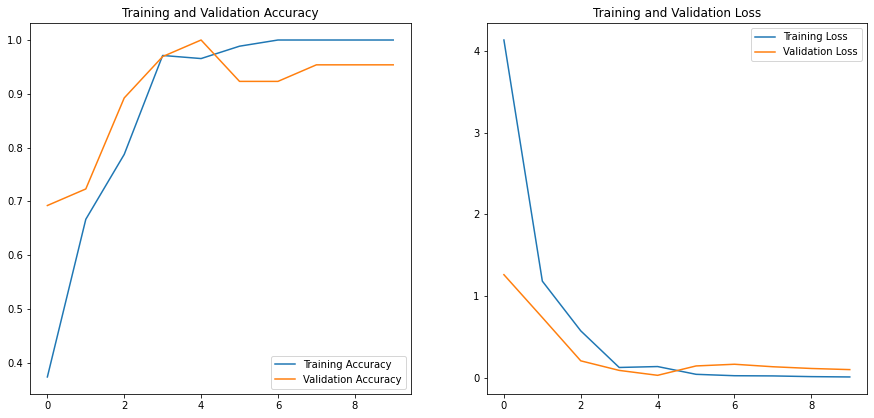

In [18]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(10)

plt.figure(figsize=(15, 15))
plt.subplot(2, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')

plt.show()




## Predicting pre processed image type

(32, 32, 3)


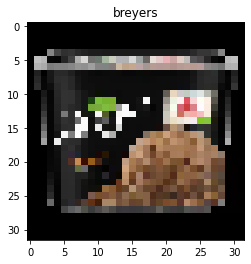

In [19]:
test_img_index = 20
img_to_predict = img_test[test_img_index]

flatten_image = img_to_predict.reshape(-1, IMG_HEIGHT*IMG_WIDTH*3)

pred_dist = model.predict(flatten_image)

pred_index = np.argmax(pred_dist[0])
pred_label = LABELS[pred_index]
data = np.asarray(img_test[test_img_index])
print(data.shape)
imgplot = plt.imshow(data)
plt.title(pred_label)
plt.show()


In [20]:
print('Done!!')

Done!!
